cuda
Users' Powers:[-13.454281 -30.943207 -24.49852  -37.66932  -14.917595] dBm ----->> SumPower : -10.867438316345215
Sigma2 Power:-40.0 dBm


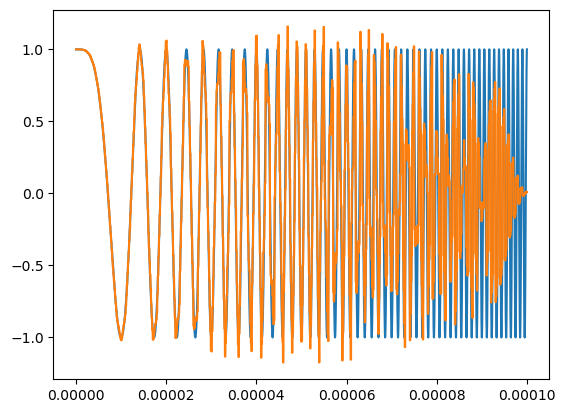

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
snr_db = 30
Ptotal_dbm = 30
comm_pulse_kind = 'CDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
snr = 10**(snr_db/10)
Ptotal = 10**((Ptotal_dbm-30)/10)

if comm_pulse_kind=='OFDMA':
    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
    sigma2 = L*Tb/snr

if comm_pulse_kind=='TDMA':
    g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
    sigma2 = L*Tb/snr/K

if comm_pulse_kind=='CDMA':
    g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])
    sigma2 = L*Tb/snr

if radar_pulse_kind=='LFM':
    radar_pulse = myRadarPulses.LFM_pulse(B)

if radar_pulse_kind=='Gaussian':
    radar_pulse = myRadarPulses.Gaussian_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)
user_bit_energy = torch.sum(torch.abs(g_vec)**2, dim=1).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

R = radar_pulse.repeat(K*L, 1)

G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])

c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)
print(f'Users\' Powers:{10*torch.log10(user_energy).cpu().numpy()+30} dBm ----->> SumPower : {10*torch.log10(user_energy.sum()).cpu().numpy()+30}')
print(f'Sigma2 Power:{10*np.log10(sigma2)+30} dBm')

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

cuda


0it [00:00, ?it/s]

Iteration 0: constraint value = -999636.688, Dual Variable = 0.000, Cost = -46.925, UpdateDistance:0.7885984182357788
	----> sumRate = 47.533, MSE = 2.019
Iteration 1000: constraint value = -970753.188, Dual Variable = 0.000, Cost = -79.173, UpdateDistance:0.0843999832868576
	----> sumRate = 79.180, MSE = 2.019
Iteration 2000: constraint value = -941894.688, Dual Variable = 0.000, Cost = -84.128, UpdateDistance:0.05986469238996506
	----> sumRate = 84.132, MSE = 2.019
Iteration 3000: constraint value = -913038.062, Dual Variable = 0.000, Cost = -87.038, UpdateDistance:0.048930488526821136
	----> sumRate = 87.041, MSE = 2.019
Iteration 4000: constraint value = -884182.250, Dual Variable = 0.000, Cost = -89.106, UpdateDistance:0.042397402226924896
	----> sumRate = 89.108, MSE = 2.019
Iteration 5000: constraint value = -855326.875, Dual Variable = 0.000, Cost = -90.711, UpdateDistance:0.03793345391750336
	----> sumRate = 90.712, MSE = 2.019
Iteration 6000: constraint value = -826471.750, D

1it [13:20, 800.11s/it]

====END 49999: constraint value = -162.000, Dual Variable = 0.000, Cost = -104.656, UpdateDistance:0.014428319409489632
	----> sumRate = 104.657, MSE = 2.019
Users' Powers:[23.010239 23.010042 23.009722 23.010387 23.009764] dBm ----->> SumPower : 29.999730777581135
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -134.562, Dual Variable = 0.000, Cost = -99.323, UpdateDistance:0.013707048259675503
	----> sumRate = 104.657, MSE = 2.019
Iteration 1000: constraint value = -37.250, Dual Variable = 0.000, Cost = -99.324, UpdateDistance:0.013706380501389503
	----> sumRate = 104.658, MSE = 2.019
Iteration 2000: constraint value = -847.500, Dual Variable = 0.000, Cost = -99.319, UpdateDistance:0.4350495934486389
	----> sumRate = 104.652, MSE = 2.019
Iteration 3000: constraint value = -600.188, Dual Variable = 0.000, Cost = -99.320, UpdateDistance:0.013710240833461285
	----> sumRate = 104.654, MSE = 2.018
Iteration 4000: constraint value = 12.000, Dual Variable = 0.000, Cost = -99.324, Upd

2it [27:06, 815.36s/it]

====END 49999: constraint value = -525.875, Dual Variable = 0.000, Cost = -99.321, UpdateDistance:0.01370973140001297
	----> sumRate = 104.654, MSE = 2.010
Users' Powers:[23.008759 23.007645 23.007957 23.008783 23.009104] dBm ----->> SumPower : 29.998149794555502
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -499.875, Dual Variable = 0.000, Cost = -93.988, UpdateDistance:0.012989110313355923
	----> sumRate = 104.654, MSE = 2.010
Iteration 1000: constraint value = -232.688, Dual Variable = 0.000, Cost = -93.989, UpdateDistance:0.012987373396754265
	----> sumRate = 104.656, MSE = 2.010
Iteration 2000: constraint value = -96.500, Dual Variable = 0.000, Cost = -93.990, UpdateDistance:0.01298649050295353
	----> sumRate = 104.657, MSE = 2.009
Iteration 3000: constraint value = -50.375, Dual Variable = 0.000, Cost = -93.991, UpdateDistance:0.012986189685761929
	----> sumRate = 104.657, MSE = 2.009
Iteration 4000: constraint value = -119.000, Dual Variable = 0.000, Cost = -93.990, Upd

3it [40:46, 817.52s/it]

====END 49999: constraint value = -714.875, Dual Variable = 0.000, Cost = -93.989, UpdateDistance:0.36701953411102295
	----> sumRate = 104.653, MSE = 1.991
Users' Powers:[23.007957 23.006794 23.006977 23.008316 23.008097] dBm ----->> SumPower : 29.997328264289536
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -690.375, Dual Variable = 0.000, Cost = -88.656, UpdateDistance:0.012270732782781124
	----> sumRate = 104.653, MSE = 1.991
Iteration 1000: constraint value = -52.812, Dual Variable = 0.000, Cost = -88.660, UpdateDistance:0.012266821227967739
	----> sumRate = 104.657, MSE = 1.991
Iteration 2000: constraint value = -516.500, Dual Variable = 0.000, Cost = -88.657, UpdateDistance:0.01226966641843319
	----> sumRate = 104.654, MSE = 1.990
Iteration 3000: constraint value = -339.750, Dual Variable = 0.000, Cost = -88.659, UpdateDistance:0.012268581427633762
	----> sumRate = 104.655, MSE = 1.990
Iteration 4000: constraint value = -525.000, Dual Variable = 0.000, Cost = -88.657, Up

4it [53:40, 800.25s/it]

====END 49999: constraint value = -386.250, Dual Variable = 0.000, Cost = -88.662, UpdateDistance:0.012268864549696445
	----> sumRate = 104.655, MSE = 1.963
Users' Powers:[23.010458 23.009115 23.007019 23.008652 23.010036] dBm ----->> SumPower : 29.998756518907612
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -363.188, Dual Variable = 0.000, Cost = -83.331, UpdateDistance:0.01155028771609068
	----> sumRate = 104.655, MSE = 1.963
Iteration 1000: constraint value = -816.562, Dual Variable = 0.000, Cost = -83.329, UpdateDistance:0.011552906595170498
	----> sumRate = 104.652, MSE = 1.962
Iteration 2000: constraint value = -816.625, Dual Variable = 0.000, Cost = -83.329, UpdateDistance:0.011552906595170498
	----> sumRate = 104.652, MSE = 1.962
Iteration 3000: constraint value = -563.875, Dual Variable = 0.000, Cost = -83.331, UpdateDistance:0.0115514462813735
	----> sumRate = 104.654, MSE = 1.961
Iteration 4000: constraint value = -8.750, Dual Variable = 0.000, Cost = -83.334, Upda

5it [1:06:43, 794.18s/it]

====END 49999: constraint value = -487.125, Dual Variable = 0.000, Cost = -83.338, UpdateDistance:0.01155098807066679
	----> sumRate = 104.654, MSE = 1.926
Users' Powers:[23.013763 23.01175  23.004272 23.005985 23.007315] dBm ----->> SumPower : 29.9983186397003
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -465.438, Dual Variable = 0.000, Cost = -78.009, UpdateDistance:0.01083365734666586
	----> sumRate = 104.654, MSE = 1.926
Iteration 1000: constraint value = -624.500, Dual Variable = 0.000, Cost = -78.009, UpdateDistance:0.010834518820047379
	----> sumRate = 104.653, MSE = 1.925
Iteration 2000: constraint value = -166.125, Dual Variable = 0.000, Cost = -78.011, UpdateDistance:0.01083203312009573
	----> sumRate = 104.657, MSE = 1.924
Iteration 3000: constraint value = -30.500, Dual Variable = 0.000, Cost = -78.012, UpdateDistance:0.010831299237906933
	----> sumRate = 104.658, MSE = 1.923
Iteration 4000: constraint value = -105.625, Dual Variable = 0.000, Cost = -78.012, Updat

6it [1:19:48, 791.21s/it]

====END 49999: constraint value = -330.438, Dual Variable = 0.000, Cost = -78.022, UpdateDistance:0.01083286665380001
	----> sumRate = 104.655, MSE = 1.879
Users' Powers:[23.021088 23.018412 23.000505 23.002361 23.004086] dBm ----->> SumPower : 29.998999133094912
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -310.250, Dual Variable = 0.000, Cost = -72.695, UpdateDistance:0.010117125697433949
	----> sumRate = 104.656, MSE = 1.879
Iteration 1000: constraint value = -489.500, Dual Variable = 0.000, Cost = -72.695, UpdateDistance:0.0101180300116539
	----> sumRate = 104.654, MSE = 1.878
Iteration 2000: constraint value = -98.125, Dual Variable = 0.000, Cost = -72.697, UpdateDistance:0.01011604629456997
	----> sumRate = 104.657, MSE = 1.877
Iteration 3000: constraint value = -431.750, Dual Variable = 0.000, Cost = -72.695, UpdateDistance:0.010117732919752598
	----> sumRate = 104.655, MSE = 1.876
Iteration 4000: constraint value = -173.500, Dual Variable = 0.000, Cost = -72.697, Upda

7it [1:32:41, 785.30s/it]

====END 49999: constraint value = -418.500, Dual Variable = 0.000, Cost = -72.712, UpdateDistance:0.21490322053432465
	----> sumRate = 104.655, MSE = 1.823
Users' Powers:[23.031271 23.027773 22.992844 22.99533  22.997196] dBm ----->> SumPower : 29.998616174561903
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -399.750, Dual Variable = 0.000, Cost = -67.387, UpdateDistance:0.009403576143085957
	----> sumRate = 104.655, MSE = 1.823
Iteration 1000: constraint value = -100.500, Dual Variable = 0.000, Cost = -67.389, UpdateDistance:0.009402161464095116
	----> sumRate = 104.657, MSE = 1.822
Iteration 2000: constraint value = 16.938, Dual Variable = 0.000, Cost = -67.390, UpdateDistance:0.009401602670550346
	----> sumRate = 104.658, MSE = 1.821
Iteration 3000: constraint value = -493.375, Dual Variable = 0.000, Cost = -67.388, UpdateDistance:0.009403996169567108
	----> sumRate = 104.654, MSE = 1.820
Iteration 4000: constraint value = -679.062, Dual Variable = 0.000, Cost = -67.388, Up

8it [1:47:19, 814.61s/it]

====END 49999: constraint value = -433.500, Dual Variable = 0.000, Cost = -67.410, UpdateDistance:0.009403330273926258
	----> sumRate = 104.655, MSE = 1.759
Users' Powers:[23.047775 23.043491 22.982368 22.983267 22.986826] dBm ----->> SumPower : 29.99855117945117
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -416.250, Dual Variable = 0.000, Cost = -62.089, UpdateDistance:0.008691616356372833
	----> sumRate = 104.655, MSE = 1.759
Iteration 1000: constraint value = -212.625, Dual Variable = 0.000, Cost = -62.091, UpdateDistance:0.00869071576744318
	----> sumRate = 104.656, MSE = 1.758
Iteration 2000: constraint value = -87.625, Dual Variable = 0.000, Cost = -62.092, UpdateDistance:0.00869015697389841
	----> sumRate = 104.657, MSE = 1.756
Iteration 3000: constraint value = -41.000, Dual Variable = 0.000, Cost = -62.092, UpdateDistance:0.00868993904441595
	----> sumRate = 104.657, MSE = 1.755
Iteration 4000: constraint value = 3.125, Dual Variable = 0.000, Cost = -62.093, UpdateDi

9it [2:01:16, 821.72s/it]

====END 49999: constraint value = -353.125, Dual Variable = 0.000, Cost = -62.118, UpdateDistance:0.008690486662089825
	----> sumRate = 104.655, MSE = 1.687
Users' Powers:[23.071615 23.066391 22.967834 22.96698  22.97179 ] dBm ----->> SumPower : 29.99890048376983
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -337.250, Dual Variable = 0.000, Cost = -56.801, UpdateDistance:0.007981495000422001
	----> sumRate = 104.655, MSE = 1.687
Iteration 1000: constraint value = 2.625, Dual Variable = 0.000, Cost = -56.803, UpdateDistance:0.007980108261108398
	----> sumRate = 104.657, MSE = 1.685
Iteration 2000: constraint value = -361.625, Dual Variable = 0.000, Cost = -56.802, UpdateDistance:0.007981531322002411
	----> sumRate = 104.655, MSE = 1.684
Iteration 3000: constraint value = -467.688, Dual Variable = 0.000, Cost = -56.803, UpdateDistance:0.007981923408806324
	----> sumRate = 104.654, MSE = 1.682
Iteration 4000: constraint value = -302.938, Dual Variable = 0.000, Cost = -56.804, Upd

10it [2:15:13, 826.39s/it]

====END 49999: constraint value = -64.125, Dual Variable = 0.000, Cost = -56.838, UpdateDistance:0.007978752255439758
	----> sumRate = 104.656, MSE = 1.607
Users' Powers:[23.105707 23.100082 22.946592 22.945723 22.950836] dBm ----->> SumPower : 30.00015531302779
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -49.750, Dual Variable = 0.000, Cost = -51.524, UpdateDistance:0.007273153401911259
	----> sumRate = 104.656, MSE = 1.607
Iteration 1000: constraint value = 2.125, Dual Variable = 0.000, Cost = -51.525, UpdateDistance:0.007272908464074135
	----> sumRate = 104.657, MSE = 1.606
Iteration 2000: constraint value = -132.500, Dual Variable = 0.000, Cost = -51.526, UpdateDistance:0.007273341063410044
	----> sumRate = 104.656, MSE = 1.604
Iteration 3000: constraint value = -189.875, Dual Variable = 0.000, Cost = -51.526, UpdateDistance:0.007273493334650993
	----> sumRate = 104.655, MSE = 1.602
Iteration 4000: constraint value = -235.250, Dual Variable = 0.000, Cost = -51.527, Updat

11it [3:22:58, 1817.58s/it]

====END 49999: constraint value = -159.250, Dual Variable = 0.000, Cost = -51.566, UpdateDistance:0.007270606234669685
	----> sumRate = 104.654, MSE = 1.522
Users' Powers:[23.149399 23.142502 22.917488 22.913853 22.9197  ] dBm ----->> SumPower : 29.999742685849924
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -146.312, Dual Variable = 0.000, Cost = -46.257, UpdateDistance:0.006569052580744028
	----> sumRate = 104.654, MSE = 1.522
Iteration 1000: constraint value = 1.125, Dual Variable = 0.000, Cost = -46.259, UpdateDistance:0.006568470969796181
	----> sumRate = 104.655, MSE = 1.520
Iteration 2000: constraint value = 12.625, Dual Variable = 0.000, Cost = -46.260, UpdateDistance:0.006568336859345436
	----> sumRate = 104.655, MSE = 1.518
Iteration 3000: constraint value = -45.875, Dual Variable = 0.000, Cost = -46.261, UpdateDistance:0.006568431854248047
	----> sumRate = 104.655, MSE = 1.517
Iteration 4000: constraint value = -89.750, Dual Variable = 0.000, Cost = -46.261, Update

12it [3:31:30, 1420.30s/it]

====END 49999: constraint value = -122.875, Dual Variable = 0.000, Cost = -46.306, UpdateDistance:0.006564036011695862
	----> sumRate = 104.652, MSE = 1.432
Users' Powers:[23.206734 23.199375 22.87971  22.87209  22.878304] dBm ----->> SumPower : 29.99990059674019
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -111.438, Dual Variable = 0.000, Cost = -41.001, UpdateDistance:0.005867662373930216
	----> sumRate = 104.652, MSE = 1.432
Iteration 1000: constraint value = -122.062, Dual Variable = 0.000, Cost = -41.002, UpdateDistance:0.005867536645382643
	----> sumRate = 104.652, MSE = 1.430
Iteration 2000: constraint value = -59.250, Dual Variable = 0.000, Cost = -41.004, UpdateDistance:0.005867193918675184
	----> sumRate = 104.652, MSE = 1.429
Iteration 3000: constraint value = -166.375, Dual Variable = 0.000, Cost = -41.005, UpdateDistance:0.005867351312190294
	----> sumRate = 104.651, MSE = 1.427
Iteration 4000: constraint value = -61.500, Dual Variable = 0.000, Cost = -41.006, Up

13it [3:40:04, 1145.74s/it]

====END 49999: constraint value = -111.500, Dual Variable = 0.000, Cost = -41.055, UpdateDistance:0.005859812721610069
	----> sumRate = 104.648, MSE = 1.340
Users' Powers:[23.280094 23.271475 22.82863  22.817902 22.824726] dBm ----->> SumPower : 29.999949780926727
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -101.375, Dual Variable = 0.000, Cost = -35.756, UpdateDistance:0.005170220974832773
	----> sumRate = 104.648, MSE = 1.340
Iteration 1000: constraint value = -58.750, Dual Variable = 0.000, Cost = -35.757, UpdateDistance:0.00516986520960927
	----> sumRate = 104.648, MSE = 1.338
Iteration 2000: constraint value = -152.125, Dual Variable = 0.000, Cost = -35.758, UpdateDistance:0.005169862415641546
	----> sumRate = 104.647, MSE = 1.336
Iteration 3000: constraint value = -329.688, Dual Variable = 0.000, Cost = -35.759, UpdateDistance:0.005170077551156282
	----> sumRate = 104.646, MSE = 1.334
Iteration 4000: constraint value = -140.688, Dual Variable = 0.000, Cost = -35.761, U

14it [3:48:50, 958.50s/it] 

====END 49999: constraint value = 4.125, Dual Variable = 0.000, Cost = -35.815, UpdateDistance:0.00515797920525074
	----> sumRate = 104.640, MSE = 1.245
Users' Powers:[23.37286  23.363075 22.763557 22.747604 22.754314] dBm ----->> SumPower : 30.00045194552513
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -152.188, Dual Variable = 0.000, Cost = -30.520, UpdateDistance:0.07818052172660828
	----> sumRate = 104.639, MSE = 1.245
Iteration 1000: constraint value = -72.625, Dual Variable = 0.000, Cost = -30.521, UpdateDistance:0.004477595444768667
	----> sumRate = 104.640, MSE = 1.243
Iteration 2000: constraint value = -322.875, Dual Variable = 0.000, Cost = -30.522, UpdateDistance:0.16567660868167877
	----> sumRate = 104.638, MSE = 1.241
Iteration 3000: constraint value = -110.500, Dual Variable = 0.000, Cost = -30.524, UpdateDistance:0.004476949106901884
	----> sumRate = 104.639, MSE = 1.240
Iteration 4000: constraint value = -20.688, Dual Variable = 0.000, Cost = -30.525, UpdateDi

15it [4:07:57, 1015.35s/it]

====END 49999: constraint value = -322.750, Dual Variable = 0.000, Cost = -30.582, UpdateDistance:0.16567616164684296
	----> sumRate = 104.625, MSE = 1.151
Users' Powers:[23.48546  23.474617 22.678202 22.654346 22.66109 ] dBm ----->> SumPower : 29.99903253359662
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -315.500, Dual Variable = 0.000, Cost = -25.293, UpdateDistance:0.0037943811621516943
	----> sumRate = 104.625, MSE = 1.151
Iteration 1000: constraint value = -200.000, Dual Variable = 0.000, Cost = -25.294, UpdateDistance:0.10265026986598969
	----> sumRate = 104.625, MSE = 1.149
Iteration 2000: constraint value = -97.000, Dual Variable = 0.000, Cost = -25.296, UpdateDistance:0.0037928950041532516
	----> sumRate = 104.625, MSE = 1.147
Iteration 3000: constraint value = -27.125, Dual Variable = 0.000, Cost = -25.297, UpdateDistance:0.0037922291085124016
	----> sumRate = 104.625, MSE = 1.145
Iteration 4000: constraint value = -84.500, Dual Variable = 0.000, Cost = -25.299, Up

16it [4:24:27, 1007.89s/it]

====END 49999: constraint value = -85.625, Dual Variable = 0.000, Cost = -25.357, UpdateDistance:0.003768602153286338
	----> sumRate = 104.604, MSE = 1.058
Users' Powers:[23.625294 23.61442  22.57214  22.536789 22.54291 ] dBm ----->> SumPower : 30.000062643593992
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -79.875, Dual Variable = 0.000, Cost = -20.074, UpdateDistance:0.0031244487036019564
	----> sumRate = 104.604, MSE = 1.058
Iteration 1000: constraint value = -141.750, Dual Variable = 0.000, Cost = -20.076, UpdateDistance:0.003123775590211153
	----> sumRate = 104.603, MSE = 1.056
Iteration 2000: constraint value = -105.000, Dual Variable = 0.000, Cost = -20.077, UpdateDistance:0.0031229506712406874
	----> sumRate = 104.602, MSE = 1.054
Iteration 3000: constraint value = -40.312, Dual Variable = 0.000, Cost = -20.079, UpdateDistance:0.003122084541246295
	----> sumRate = 104.602, MSE = 1.052
Iteration 4000: constraint value = -60.688, Dual Variable = 0.000, Cost = -20.080, U

17it [4:41:32, 1013.06s/it]

====END 49999: constraint value = -47.250, Dual Variable = 0.000, Cost = -20.140, UpdateDistance:0.0030882596038281918
	----> sumRate = 104.568, MSE = 0.966
Users' Powers:[23.79435  23.783346 22.432558 22.382301 22.389366] dBm ----->> SumPower : 30.000229343640967
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -42.938, Dual Variable = 0.000, Cost = -14.864, UpdateDistance:0.0024842265993356705
	----> sumRate = 104.568, MSE = 0.966
Iteration 1000: constraint value = -89.312, Dual Variable = 0.000, Cost = -14.865, UpdateDistance:0.0024831853806972504
	----> sumRate = 104.566, MSE = 0.964
Iteration 2000: constraint value = -86.000, Dual Variable = 0.000, Cost = -14.867, UpdateDistance:0.002482085023075342
	----> sumRate = 104.565, MSE = 0.962
Iteration 3000: constraint value = -54.250, Dual Variable = 0.000, Cost = -14.868, UpdateDistance:0.02786240167915821
	----> sumRate = 104.564, MSE = 0.961
Iteration 4000: constraint value = -89.125, Dual Variable = 0.000, Cost = -14.870, Upd

18it [5:00:25, 1048.99s/it]

====END 49999: constraint value = -37.500, Dual Variable = 0.000, Cost = -14.932, UpdateDistance:0.0024326068814843893
	----> sumRate = 104.508, MSE = 0.876
Users' Powers:[23.998222 23.987019 22.250957 22.179695 22.18629 ] dBm ----->> SumPower : 30.00027127649446
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -34.625, Dual Variable = 0.000, Cost = -9.662, UpdateDistance:0.0019104266539216042
	----> sumRate = 104.508, MSE = 0.876
Iteration 1000: constraint value = -14.688, Dual Variable = 0.000, Cost = -9.664, UpdateDistance:0.0019088464323431253
	----> sumRate = 104.506, MSE = 0.874
Iteration 2000: constraint value = -80.000, Dual Variable = 0.000, Cost = -9.666, UpdateDistance:0.04107629880309105
	----> sumRate = 104.504, MSE = 0.872
Iteration 3000: constraint value = -57.000, Dual Variable = 0.000, Cost = -9.667, UpdateDistance:0.0019057749304920435
	----> sumRate = 104.502, MSE = 0.870
Iteration 4000: constraint value = -24.125, Dual Variable = 0.000, Cost = -9.669, UpdateDi

19it [5:15:50, 1011.81s/it]

====END 49999: constraint value = -15.688, Dual Variable = 0.000, Cost = -9.734, UpdateDistance:0.001836384297348559
	----> sumRate = 104.410, MSE = 0.786
Users' Powers:[24.24437  24.232437 22.00929  21.908104 21.91334 ] dBm ----->> SumPower : 30.00036601217289
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -14.250, Dual Variable = 0.000, Cost = -4.474, UpdateDistance:0.0014984675217419863
	----> sumRate = 104.410, MSE = 0.786
Iteration 1000: constraint value = -29.750, Dual Variable = 0.000, Cost = -4.476, UpdateDistance:0.0014964420115575194
	----> sumRate = 104.407, MSE = 0.784
Iteration 2000: constraint value = -24.250, Dual Variable = 0.000, Cost = -4.477, UpdateDistance:0.0014944033464416862
	----> sumRate = 104.404, MSE = 0.782
Iteration 3000: constraint value = -30.250, Dual Variable = 0.000, Cost = -4.479, UpdateDistance:0.015583517961204052
	----> sumRate = 104.401, MSE = 0.780
Iteration 4000: constraint value = 0.188, Dual Variable = 0.000, Cost = -4.481, UpdateDista

20it [5:30:31, 972.60s/it] 

====END 49999: constraint value = -1.125, Dual Variable = 0.000, Cost = -4.553, UpdateDistance:0.0013990069273859262
	----> sumRate = 104.246, MSE = 0.694
Users' Powers:[24.541424 24.528557 21.67828  21.532894 21.533915] dBm ----->> SumPower : 30.000429168176197
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -1.125, Dual Variable = 0.000, Cost = 0.694, UpdateDistance:0.0014317403547465801
	----> sumRate = 104.246, MSE = 0.694
Iteration 1000: constraint value = -1.875, Dual Variable = 0.000, Cost = 0.692, UpdateDistance:0.0014298715395852923
	----> sumRate = 104.241, MSE = 0.692
Iteration 2000: constraint value = -1.688, Dual Variable = 0.000, Cost = 0.690, UpdateDistance:0.0014280007453635335
	----> sumRate = 104.236, MSE = 0.690
Iteration 3000: constraint value = -2.250, Dual Variable = 0.000, Cost = 0.688, UpdateDistance:0.0014261303003877401
	----> sumRate = 104.231, MSE = 0.688
Iteration 4000: constraint value = -1.125, Dual Variable = 0.000, Cost = 0.686, UpdateDistance:0.

C:\Users\Ali\AppData\Local\Temp\ipykernel_9624\3187533196.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
21it [5:39:45, 970.76s/it]

====END 49999: constraint value = -16.688, Dual Variable = 0.000, Cost = 0.598, UpdateDistance:0.0013380281161516905
	----> sumRate = 103.964, MSE = 0.598
Users' Powers:[24.899557 24.88625  21.202873 20.99165  20.98536 ] dBm ----->> SumPower : 30.00036135308619
Sigma2 Power:-40.0 dBm


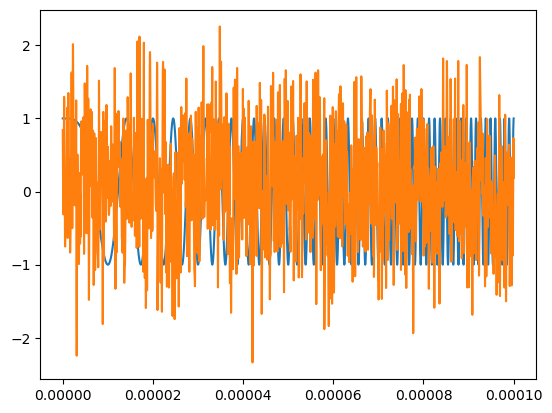

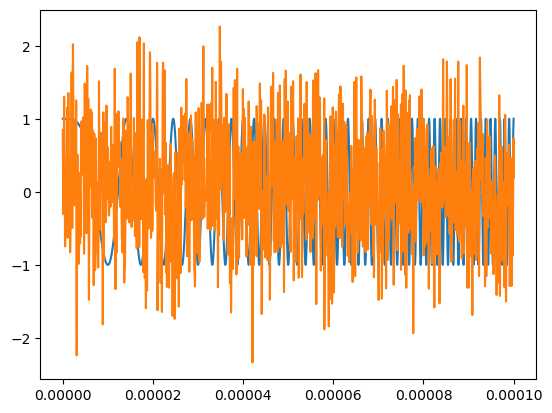

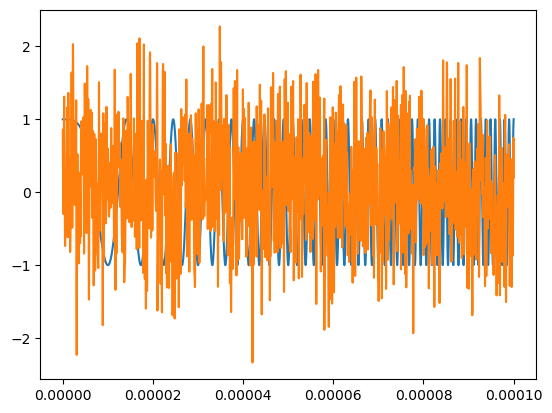

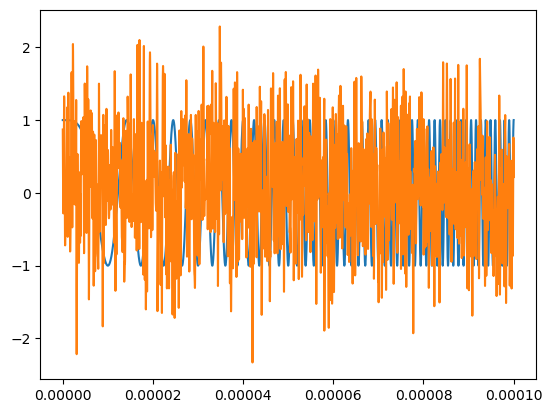

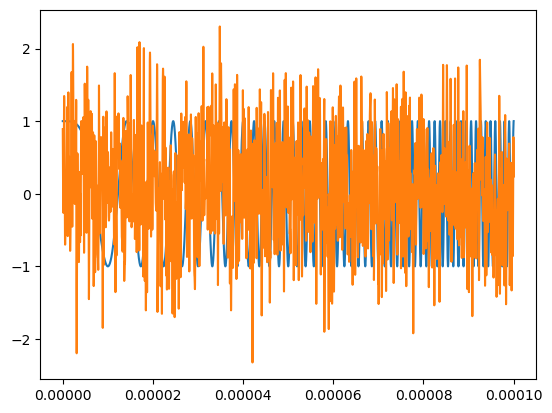

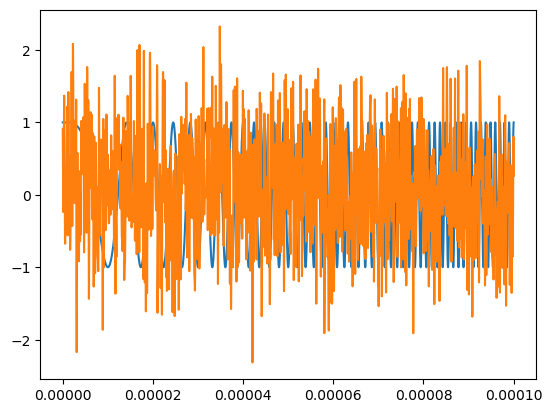

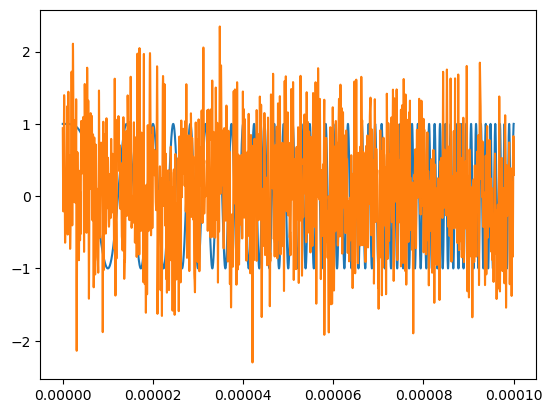

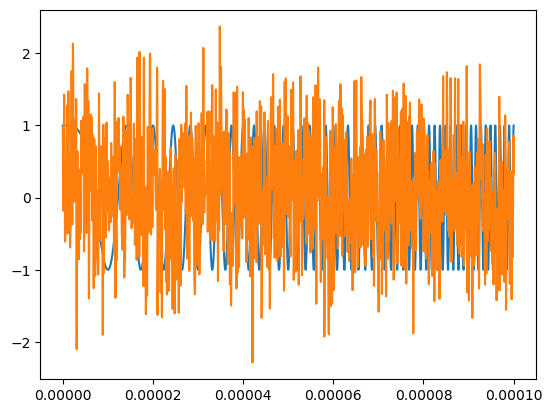

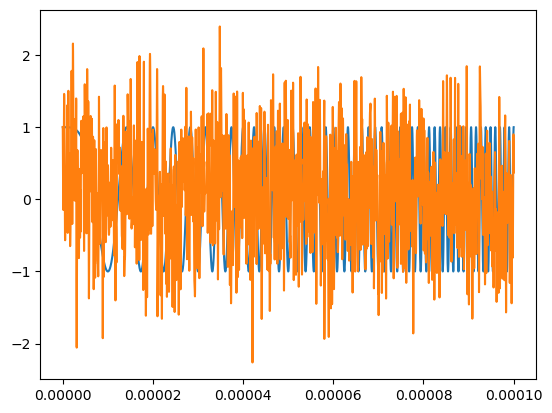

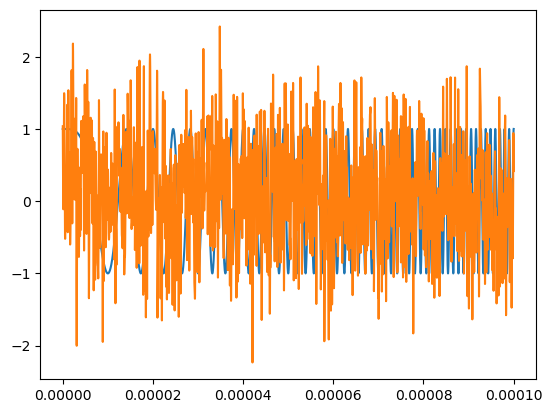

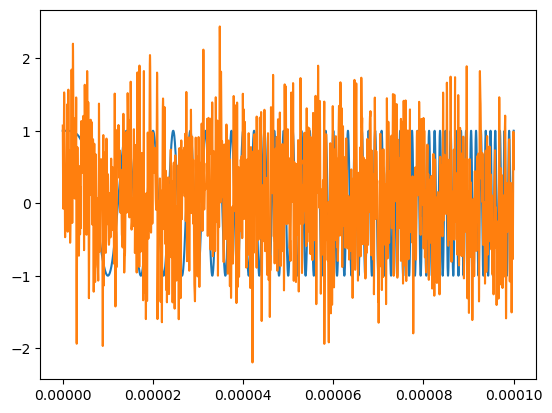

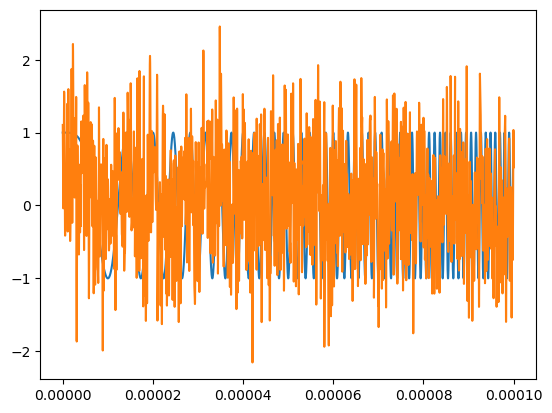

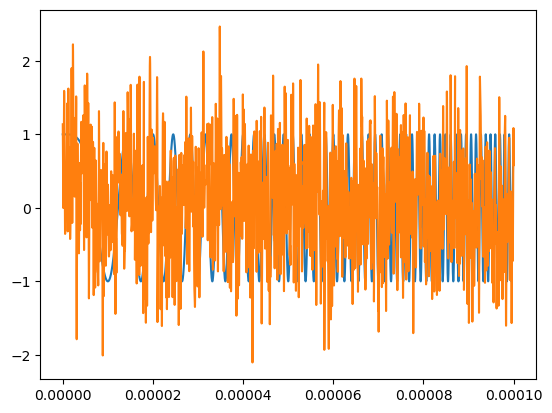

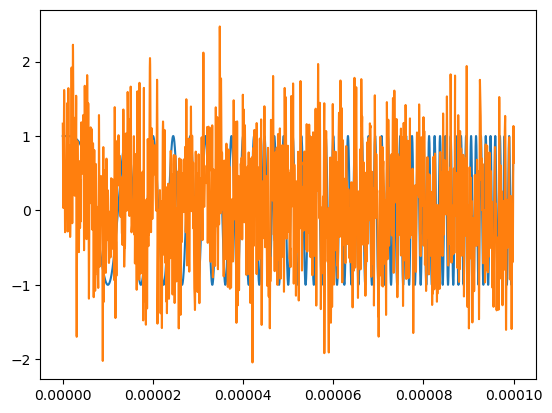

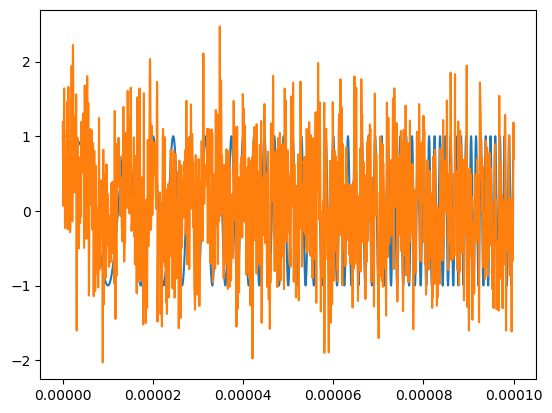

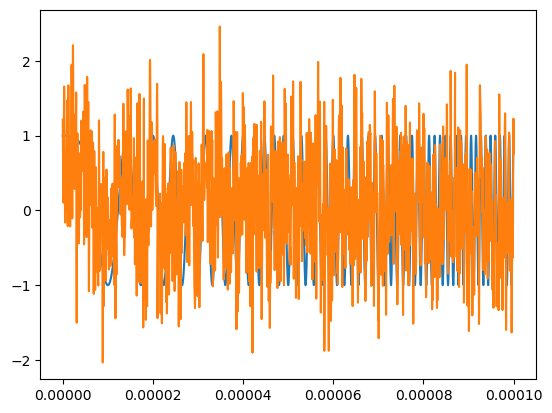

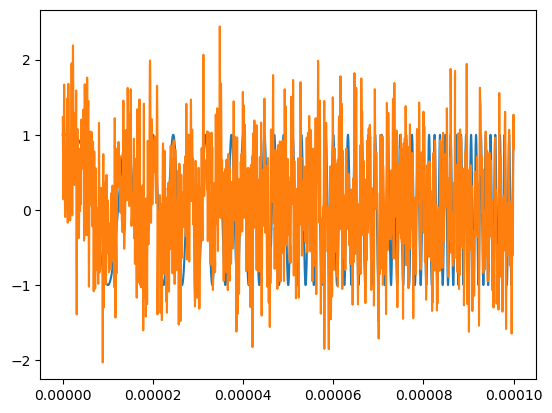

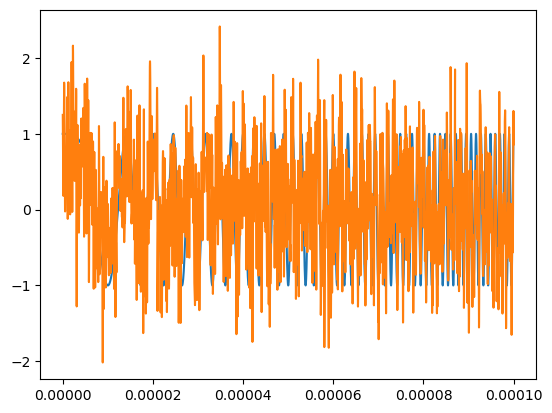

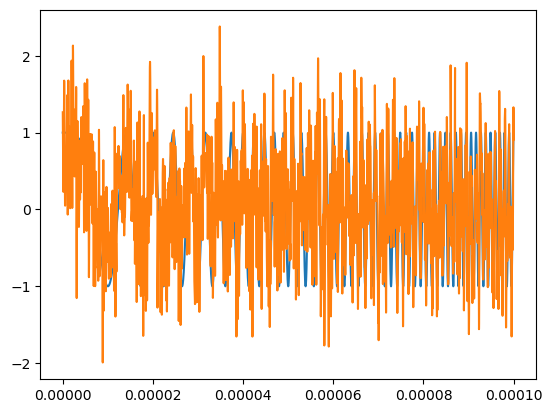

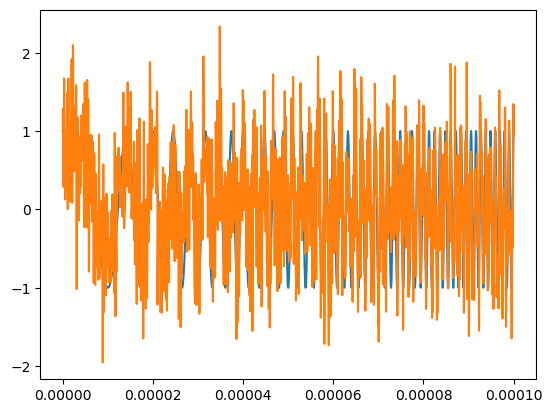

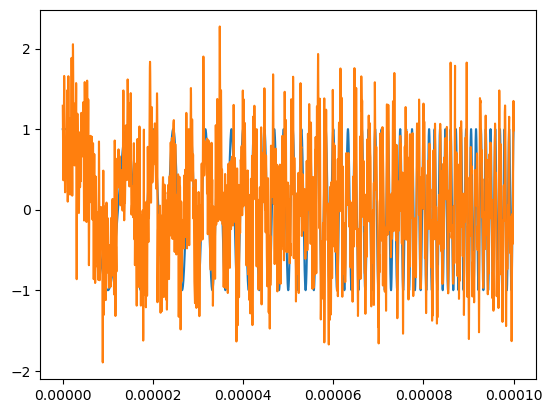

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch
from multiprocessing import Pool
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
# radar_pulse = myRadarPulses.Gaussian_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

def total_max_power_constr(coff):
     return torch.sum(torch.abs(coff)**2) - Ptotal/Tb

def get_mse(coff):
    s = torch.sum(coff[:, None] * g_vec, dim=0)
    s = s / torch.sqrt(torch.mean(s.abs()**2))
    return torch.mean(torch.abs(s - radar_pulse / torch.sqrt(torch.mean(radar_pulse.abs()**2))) ** 2) # Compute MSE loss
    # return torch.mean(torch.abs(s - radar_pulse) ** 2) # Compute MSE loss

def get_gamma(coff):
    return (torch.abs(coff)**2).reshape((L, K)).sum(dim=0) * Tb / sigma2 #for OFDMA and CDMA

# Fitness function
def cost_function(coff, coff_old, dual_lambda, theta):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """

    sumrate = torch.sum(torch.log2(1 + get_gamma(coff)))
    sumrate_old = torch.sum(torch.log2(1 + get_gamma(coff_old)))
    return theta*get_mse(coff) - (1-theta)*sumrate+ dual_lambda*(total_max_power_constr(coff))

# Initialize individual with real and imaginary parts
init_c = torch.rand(K * L * 2, device=device, requires_grad=True) * 2 - 1
real_val = init_c[:len(init_c)//2]  # Real part
imag_val = init_c[len(init_c)//2:]  # Imaginary part
# Combine real and imaginary parts into complex tensor
c = real_val + 1j * imag_val  # Combine parts to form a complex number

c.retain_grad()

dual = 0
dual_update_rate = 1e-5
Theta = np.linspace(0,1,21)
MSEs = np.zeros(len(Theta))
SumRates = np.zeros(len(Theta))
for idx, theta in tqdm(enumerate(Theta)):
    primal_update_rate = 1e-4
    for itr in range(100000):

        # Call the fitness function with the complex individual
        c_old = c.detach()
        cost = cost_function(c, c_old, dual, theta)
        
        # Backpropagate to compute gradients
        cost.backward(retain_graph=True)
        delta_x = -c.grad
        t_coff = 1
        alpha = 0.005
        beta = 0.9

        with torch.no_grad():
            loop_cont = 0
            for _ in range(1000):
                loop_cont += 1
                new_cost = cost_function(c + t_coff*delta_x, c_old, dual, theta).item()
                old_cost = cost.item()
                if new_cost <= old_cost - alpha*t_coff*torch.sum(delta_x.abs()**2):
                    break
                else:
                    t_coff *= beta

            if torch.linalg.norm(t_coff * delta_x) < 1e-6:
                print("Early Stopping")
                break
            
            c += t_coff * delta_x  # Update rule
            dual = max(0, dual + dual_update_rate * total_max_power_constr(c))
            
            if itr % 1000 == 0:
                print(f"Iteration {itr}: constraint value = {total_max_power_constr(c).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}, UpdateDistance:{torch.linalg.norm(t_coff * delta_x)}")
                print(f'\t----> sumRate = {torch.sum(torch.log2(1 + get_gamma(c))).item():0.3f}, MSE = {get_mse(c).item():0.3f}')    

        c.grad.zero_()
    

    c_opt = c.detach()
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    MSEs[idx] = get_mse(c_opt).item()
    SumRates[idx] = torch.sum(torch.log2(1 + get_gamma(c_opt))).cpu().numpy()
    print(f"====END {itr}: constraint value = {total_max_power_constr(c_opt).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}, UpdateDistance:{torch.linalg.norm(t_coff * delta_x)}")
    print(f'\t----> sumRate = {SumRates[idx]:0.3f}, MSE = {MSEs[idx]:0.3f}')  
    user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
    user_energy = user_bit_energy.sum(dim=0)
    print(f'Users\' Powers:{10*torch.log10(user_energy).cpu().numpy()+30} dBm ----->> SumPower : {10*torch.log10(user_energy.sum()).cpu().numpy()+30}')
    print(f'Sigma2 Power:{10*np.log10(sigma2)+30} dBm')

    plt.figure()
    plt.plot(t.cpu(), (radar_pulse/torch.sqrt(torch.mean(radar_pulse.abs()**2))).cpu().real)
    plt.plot(t.cpu(), (s_opt/torch.sqrt(torch.mean(s_opt.abs()**2))).cpu().real)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

# Fitness function
def fitness_fn(individual):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """
    N = len(individual) // 2
    # individual = np.clip(individual, -1, 1)
    real_val = torch.tensor(individual[:N], device=device, dtype=torch.float32)
    imag_val = torch.tensor(individual[N:], device=device, dtype=torch.float32)
    
    # Combine real and imaginary parts into complex tensor
    c_opt = real_val + 1j * imag_val
    c_opt = c_opt.to(torch.complex64)
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    s_opt_normalized = s_opt
    radar_pulse_normalized = radar_pulse
    mse = (torch.mean(torch.abs(s_opt_normalized - radar_pulse_normalized) ** 2)).item()
    return mse,

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, L * K * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=20)

# Genetic algorithm execution
population = toolbox.population(n=500)
n_generations = 1000

stats = Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", lambda a: np.mean(a))
stats.register("Min", lambda a: np.min(a))
# Run the genetic algorithm
result, log = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations, verbose=True, stats=stats
)

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
N = len(best_individual) // 2
real_val = torch.tensor(best_individual[:N], device=device, dtype=torch.float32)
imag_val = torch.tensor(best_individual[N:], device=device, dtype=torch.float32)

# Combine real and imaginary parts into complex tensor
c_opt_optimized = real_val + 1j * imag_val
c_opt_optimized = c_opt_optimized.to(torch.complex64).to(device)

# Synthesize optimized signal
s_opt_optimized = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

In [ ]:
radar_pulse_power = (radar_pulse.abs()**2).sum()
s_opt_optimized2 = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0) * torch.sqrt(radar_pulse_power / (s_opt_optimized.abs()**2).sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized2.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

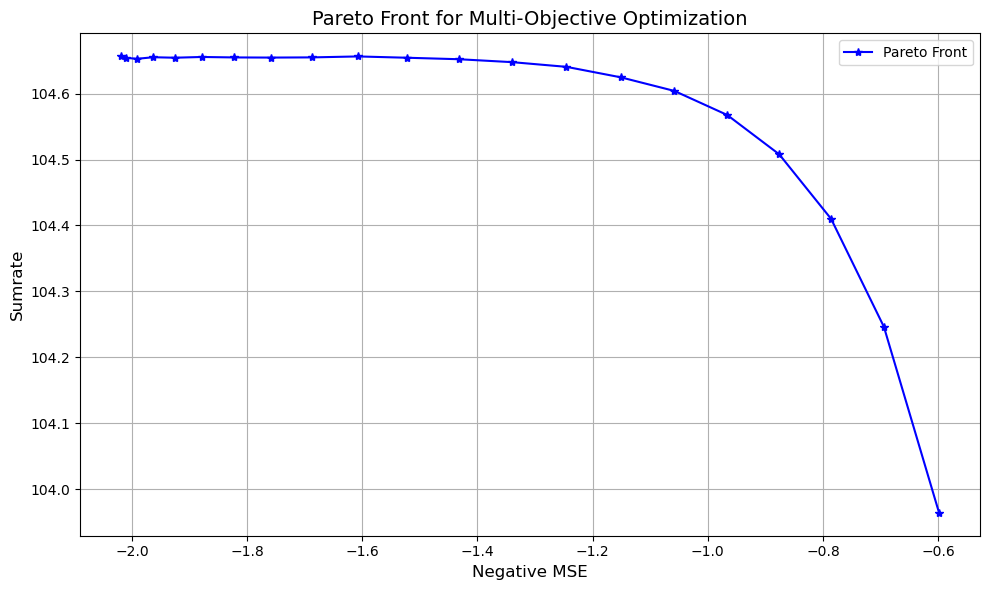

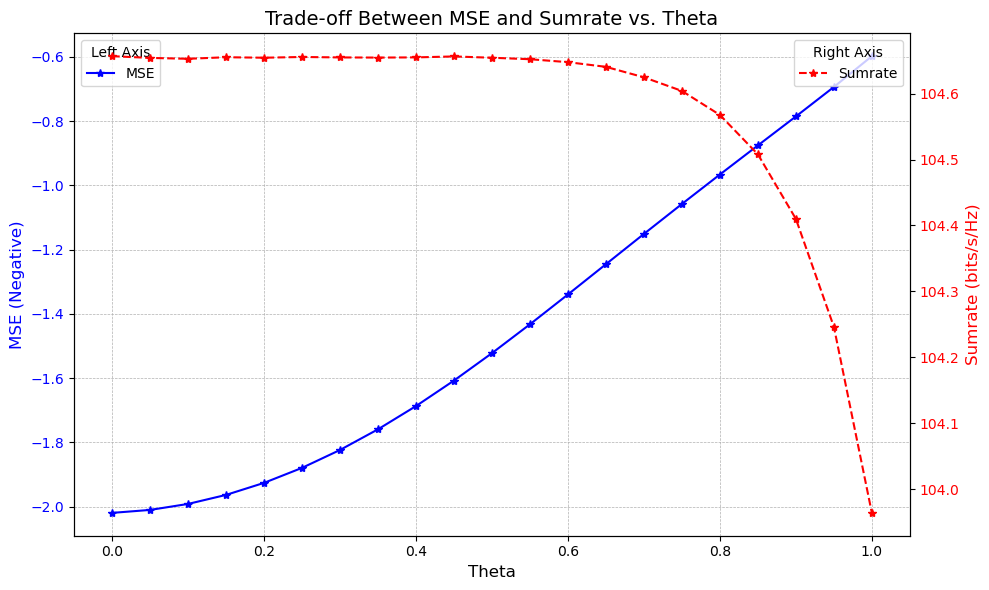

In [7]:
plt.figure(figsize=(10, 6))
plt.grid()

# Plot the Pareto Front
plt.plot(-MSEs, SumRates, '*-', label="Pareto Front", color="b")

# Fill the area under the Pareto points
# plt.fill_between(-MSEs, SumRates, alpha=0.3, color="blue", label="Feasible Region")
# plt.ylim([1*min(SumRates), 1.05*max(SumRates)])
# Add labels, title, and legend
plt.xlabel("Negative MSE", fontsize=12)
plt.ylabel("Sumrate", fontsize=12)
plt.title("Pareto Front for Multi-Objective Optimization", fontsize=14)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


# Create a figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE (left y-axis)
ax1.plot(Theta, -MSEs, 'b*-', label="MSE")
ax1.set_xlabel('Theta', fontsize=12)
ax1.set_ylabel('MSE (Negative)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b', labelsize=10)
ax1.set_title("Trade-off Between MSE and Sumrate vs. Theta", fontsize=14)

# Create a secondary y-axis for Sumrate
ax2 = ax1.twinx()
ax2.plot(Theta, SumRates, 'r*--', label="Sumrate")
ax2.set_ylabel('Sumrate (bits/s/Hz)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r', labelsize=10)

# Add legends for both axes
ax1.legend(loc="upper left", fontsize=10, title="Left Axis")
ax2.legend(loc="upper right", fontsize=10, title="Right Axis")

# Add grid for clarity
ax1.grid(visible=True, which="major", linestyle="--", linewidth=0.5)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()
